In [8]:
import os
import itertools
#hi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from joblib import Parallel, delayed
from sklearn import metrics
from aequitas.group import Group

from autodefer.models import haic
from autodefer.utils import thresholding as t, plotting
import pickle

import json

sns.set_style('whitegrid')

MODELS_PATH = './models/'

cfg_path = 'cfg.yaml'
with open(cfg_path, 'r') as infile:
    cfg = yaml.safe_load(infile)


data_cfg_path = '../data/dataset_cfg.yaml'

with open(data_cfg_path, 'r') as infile:
    data_cfg = yaml.safe_load(infile)


cat_dict = data_cfg['categorical_dict']

LABEL_COL = 'fraud_label'
PROTECTED_COL = 'customer_age'
CATEGORICAL_COLS = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'assignment']
TIMESTAMP_COL = 'month'
SCORE_COL = 'model_score'
BATCH_COL = 'batch'
ASSIGNMENT_COL = 'assignment'
DECISION_COL = 'decision'


expert_ids_path = '/mnt/home/jean.alves/Clean_May/experts/expert_info_30_05_2023/expert_ids.yaml'

with open(expert_ids_path, 'r') as infile:
    EXPERT_IDS = yaml.safe_load(infile)
#EXPERT_IDS = metadata['expert_ids']

# Expert behavior model performance

In [9]:
RMAs = dict()

for train_env in os.listdir(MODELS_PATH):
    RMAs[train_env] = haic.assigners.RiskMinimizingAssigner(
        expert_ids=EXPERT_IDS,
        outputs_dir=f'{MODELS_PATH}{train_env}/human_expertise_model/',
    )
    calibrator_path = f'{MODELS_PATH}{train_env}/calibrator.pickle'
    RMAs[train_env].load(CATEGORICAL_COLS, SCORE_COL, ASSIGNMENT_COL, calibrator_path, cat_dict)

#Data and Models are now Loaded

In [10]:
#We use this function to obtain the outcomes of each expert's prediction. 
test = pd.read_parquet('../testbed/test/test.parquet')
test_expert_pred = pd.read_parquet('../testbed/test/test_expert_pred.parquet')

def cat_checker(data, features, cat_dict):
    new_data = data.copy()
    for feature in features:
        if new_data[feature].dtype != 'category':
            print(f'{feature} has been reencoded')
            new_data[feature] = pd.Categorical(new_data[feature].values, categories=cat_dict[feature])
        elif new_data[feature].dtype.categories.to_list() == cat_dict[feature]:
            print(f'{feature} has the correct categories')
        else:
            new_data[feature] = pd.Categorical(new_data[feature].values, categories=cat_dict[feature])
    
    return new_data


cat_dict['assignment'] = EXPERT_IDS['human_ids'] + EXPERT_IDS['model_ids']

test = cat_checker(test, data_cfg['data_cols']['categorical'], cat_dict)

def get_outcome(label, pred):
    if pred == 1:
        if label == 1:
            o = 'tp'
        elif label == 0:
            o = 'fp'
    elif pred == 0:
        if label == 1:
            o = 'fn'
        elif label == 0:
            o = 'tn'
    return o

#The models take as input a dataframe consisting of features, followed by model_score, followed by assignment
test['assignment'] = 'blank'

outcomes = pd.DataFrame()
outcomes['labels'] = test['fraud_label']
test = test.drop(columns = ['fraud_label', 'month'])
roc_curves = dict()
if os.path.isfile('roc_curves.pkl'):
    with open('roc_curves.pkl', 'rb') as fp:
        roc_curves = pickle.load(fp)
else:
    for env_id in os.listdir(MODELS_PATH):
        print(env_id)
        if env_id != 'small_regular':
            continue
        curves = dict()
        for expert in EXPERT_IDS['human_ids']:
            model = RMAs[env_id]
            outcomes['decisions'] = test_expert_pred[expert]
            outcomes['outcomes'] = outcomes.apply(lambda x: get_outcome(label=x['labels'], pred=x['decisions']),
                axis=1,
            )
            
            test['assignment'] = expert
            
            test = cat_checker(test, data_cfg['data_cols']['categorical'] + ['assignment'], cat_dict)

            pred_proba = model.expert_model.predict_proba(test)
            fp_fpr, fp_tpr,_ = metrics.roc_curve(y_true = (outcomes['outcomes'] == 'fp').astype(int), y_score = pred_proba[:, model.expert_model.classes_ == 'fp'].squeeze())
            fn_fpr, fn_tpr,_ = metrics.roc_curve(y_true = (outcomes['outcomes'] == 'fn').astype(int), y_score = pred_proba[:, model.expert_model.classes_ == 'fn'].squeeze())
            
            curves[expert]= {'fp_fpr': fp_fpr,
                            'fp_tpr': fp_tpr,
                            'fn_fpr': fn_fpr,
                            'fn_tpr': fn_tpr,
                            }
            
        roc_curves[env_id] = curves
    with open('roc_curves.pkl', 'wb') as fp:
        pickle.dump(roc_curves, fp)
        


payment_type has the correct categories
employment_status has the correct categories
housing_status has the correct categories
source has the correct categories
device_os has the correct categories
small_regular
payment_type has the correct categories
employment_status has the correct categories
housing_status has the correct categories
source has the correct categories
device_os has the correct categories
assignment has been reencoded
payment_type has the correct categories
employment_status has the correct categories
housing_status has the correct categories
source has the correct categories
device_os has the correct categories
assignment has been reencoded
payment_type has the correct categories
employment_status has the correct categories
housing_status has the correct categories
source has the correct categories
device_os has the correct categories
assignment has been reencoded
payment_type has the correct categories
employment_status has the correct categories
housing_status has 

In [11]:
pal = sns.color_palette(['C0','C2', 'C3'])
pal = pal.as_hex()

dict_keys(['small_regular'])


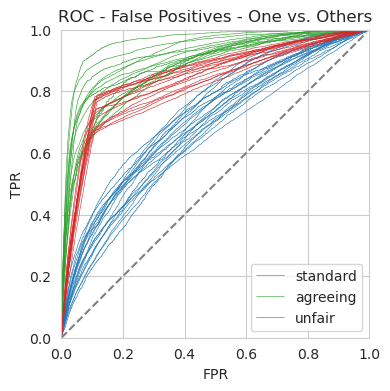

In [12]:


f, ax = plt.subplots(figsize=(4, 4))

print(roc_curves.keys())
train_env = 'small_regular'
exp = roc_curves[train_env]


reg_counter = 0
ma_counter = 0
un_counter = 0
for expert in EXPERT_IDS['human_ids']:
    setlabel = None
    if expert.split('#')[0] == 'regular':
        color = pal[0]
        if(reg_counter == 0):
            setlabel = 'standard'
            reg_counter +=1
    elif expert.split('#')[0] == 'model_agreeing':
        color = pal[1]
        if(ma_counter == 0):
            setlabel = 'agreeing'
            ma_counter+=1
    elif expert.split('#')[0] == 'unfair':
        color = pal[2]
        if(un_counter == 0):
            setlabel = 'unfair'
            un_counter += 1
    plt.plot(exp[expert]['fp_fpr'],exp[expert]['fp_tpr'], c = color, linewidth = 0.4, label = setlabel)


plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC - False Positives - One vs. Others')
plt.legend()
plt.savefig("ROC_FP_OvO.pdf", format="pdf", bbox_inches="tight")
plt.show()

dict_keys(['small_regular'])


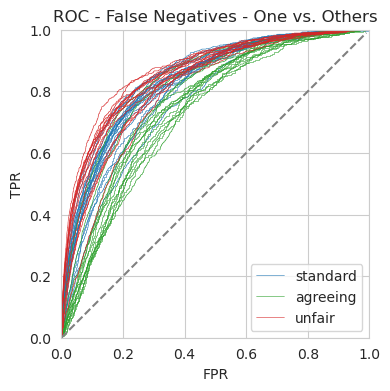

In [13]:
f, ax = plt.subplots(figsize=(4, 4))



print(roc_curves.keys())
exp = roc_curves['small_regular']

reg_counter = 0
ma_counter = 0
un_counter = 0

for expert in EXPERT_IDS['human_ids']:
    setlabel = None
    if expert.split('#')[0] == 'regular':
        color = pal[0]
        if(reg_counter == 0):
            setlabel = 'standard'
            reg_counter +=1
    elif expert.split('#')[0] == 'model_agreeing':
        color = pal[1]
        if(ma_counter == 0):
            setlabel = 'agreeing'
            ma_counter+=1
    elif expert.split('#')[0] == 'unfair':
        color = pal[2]
        if(un_counter == 0):
            setlabel = 'unfair'
            un_counter += 1
    plt.plot(exp[expert]['fn_fpr'],exp[expert]['fn_tpr'], c = color, linewidth = 0.4, label = setlabel)

plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC - False Negatives - One vs. Others')
plt.legend()
plt.savefig("ROC_FN_OvO.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [14]:
#Calibration of these estimates shouldnt be done on the data that was used to train them, right?
#In that case I would suggest using the data where the experts were tweaked, since their behavior is the same there anyways. It was used
#to tweak the beta and alpha intercepts, but their behavior is the same on the rest of the data
#I will use month 6 as it was the validation for said training, apparent in the main
import pandas as pd
from sklearn.isotonic import IsotonicRegression
test_pred = pd.read_parquet('/mnt/home/jean.alves/Clean_May/experts/expert_info_30_05_2023/deployment_predictions.parquet')
val = pd.read_parquet('/mnt/home/jean.alves/Clean_May/data/BAF.parquet')
model = RMAs['small_regular']

expert = 'regular#0'

test = pd.read_parquet('../testbed/test/test.parquet')
test = test.drop(columns = 'month')

test_expert_pred = test_pred.loc[test.index]
test['model_score'] = test_expert_pred['model#0']


predicted_fp = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
predicted_fn = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
label_fp = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
label_fn = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])

for expert in EXPERT_IDS['human_ids']:
    test['assignment'] = expert 
    test = cat_checker(test, data_cfg['data_cols']['categorical'] + ['assignment'], cat_dict)

    outcomes = pd.DataFrame()
    outcomes['labels'] = test['fraud_label']
    outcomes['decisions'] = test_expert_pred[expert]
    outcomes['outcomes'] = outcomes.apply(lambda x:    get_outcome(label=x['labels'], pred=x['decisions']),
                    axis=1,
            )
    
    pred_proba = model.expert_model.predict_proba(test.drop(columns = 'fraud_label'))

    label_fp[expert]=(outcomes['outcomes'] == 'fp').astype(int)
    predicted_fp[expert]=pred_proba[:, model.expert_model.classes_ == 'fp'].squeeze()
    label_fn[expert]=(outcomes['outcomes'] == 'fn').astype(int)
    predicted_fn[expert]=pred_proba[:, model.expert_model.classes_ == 'fn'].squeeze()



"""ASSIGNMENT_COL
val['assignment'] = expert
            
val = cat_checker(val, data_cfg['data_cols']['categorical'] + ['assignment'], cat_dict)

pred_proba = model.expert_model.predict_proba(val)

y_true=(outcomes['outcomes'] == 'fp').astype(int)
y_pred=pred_proba[:, model.expert_model.classes_ == 'fp'].squeeze()
gb_y, gb_x = calibration_curve(y_true, y_pred)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(gb_x, gb_y, marker='.')
plt.show()
"""
test





payment_type has the correct categories
employment_status has the correct categories
housing_status has the correct categories
source has the correct categories
device_os has the correct categories
assignment has been reencoded
payment_type has the correct categories
employment_status has the correct categories
housing_status has the correct categories
source has the correct categories
device_os has the correct categories
assignment has been reencoded
payment_type has the correct categories
employment_status has the correct categories
housing_status has the correct categories
source has the correct categories
device_os has the correct categories
assignment has been reencoded
payment_type has the correct categories
employment_status has the correct categories
housing_status has the correct categories
source has the correct categories
device_os has the correct categories
assignment has been reencoded
payment_type has the correct categories
employment_status has the correct categories
hou

,fraud_label,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,model_score,assignment
case_id,,,,,,,,,,,,,,,,,,,,,
903157,0,0.7,0.263599,-1,66,30,0.000363,-1.045411,AB,2355,...,1500.0,0,INTERNET,2.758498,other,1,1,0,0.016051,unfair#14
903158,0,0.8,0.514795,-1,20,10,0.004824,-1.502697,AB,80,...,200.0,0,INTERNET,3.595888,other,1,1,0,0.002822,unfair#14
903159,0,0.9,0.353230,-1,171,30,0.042901,39.376838,AA,1128,...,1500.0,0,INTERNET,4.553037,linux,0,1,0,0.020464,unfair#14
903160,0,0.7,0.444915,-1,105,40,0.026872,-0.920367,AC,1236,...,500.0,0,INTERNET,16.283810,windows,0,1,0,0.056917,unfair#14
903161,0,0.1,0.001937,-1,32,20,0.006517,-0.205747,AC,524,...,200.0,0,INTERNET,2.238657,linux,0,1,0,0.006225,unfair#14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.8,0.520382,63,11,40,0.009525,17.892831,AA,238,...,200.0,0,INTERNET,13.753811,linux,1,1,0,0.000219,unfair#14
999996,0,0.9,0.041733,-1,148,50,0.027464,30.132579,AA,1268,...,200.0,0,INTERNET,2.203107,other,0,1,0,0.027278,unfair#14
999997,0,0.1,0.303791,-1,32,30,0.004134,-1.413302,AC,1056,...,200.0,0,INTERNET,7.904226,linux,1,1,0,0.002412,unfair#14


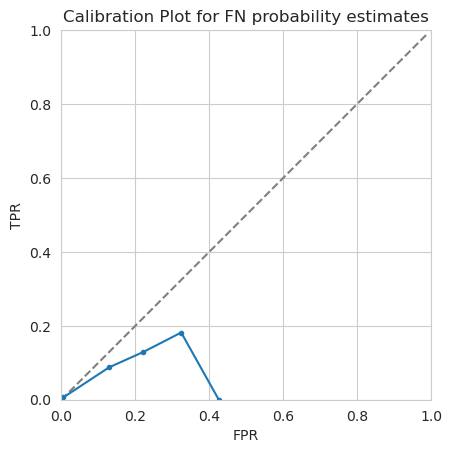

In [15]:
predicted_fn.melt()
label_fn.melt()
from sklearn.calibration import calibration_curve
gb_y, gb_x = calibration_curve(label_fn.melt()['value'], predicted_fn.melt()['value'], n_bins=10)

pal = sns.color_palette(['C0','C2', 'C3'])
pal = pal.as_hex()

plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
# plot model reliability
plt.plot(gb_x, gb_y, marker='.', color = pal[0])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'Calibration Plot for FN probability estimates')
plt.savefig("Cal_FN.pdf", format="pdf", bbox_inches="tight")
plt.show()

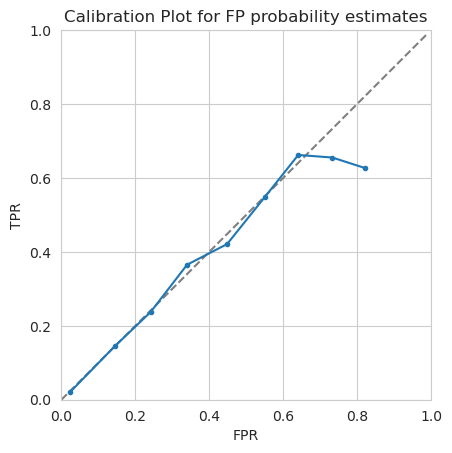

In [16]:
predicted_fn.melt()
label_fn.melt()

gb_y, gb_x = calibration_curve(label_fp.melt()['value'], predicted_fp.melt()['value'], n_bins = 10)

plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
# plot model reliability
plt.plot(gb_x, gb_y, marker='.', color = pal[0])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'Calibration Plot for FP probability estimates')
plt.savefig("Cal_FP.pdf", format="pdf", bbox_inches="tight")
plt.show()